In [287]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as sps


sns.set()

# SCRAPES THE LATEST DATA FROM WORLDOMETERS
url = 'https://www.worldometers.info/coronavirus/#countries'

r = requests.get(url)

c = r.content

soup = bs(c,'html.parser')

main_table = soup.findAll('table',{'id':'main_table_countries'})

table = main_table[0]

body = table.find('tbody')
rows = body.findAll('tr')

countries = dict()

for r in rows:
    td = r.findAll('td')
    name = td[0].get_text().strip()
    confirmed = td[1].get_text().strip()
    inc = td[2].get_text().strip()
    deaths = td[3].get_text().strip()
    d_inc = td[4].get_text().strip()
    recovered = td[5].get_text().strip()
    active_cases = td[6].get_text().strip()
    serious = td[7].get_text().strip()
    conf_p_M = td[8].get_text().strip()
    countries[name] = [confirmed,inc,deaths,d_inc,
                       recovered,active_cases,serious,conf_p_M]

cols = ['confirmed','inc','dead','dead_inc','recovered',
        'active_cases','serious','confirmed_per_M']

df = pd.DataFrame.from_dict(countries)
df = df.T
df.columns = cols



df[['inc','dead_inc']] = df[['inc','dead_inc']].apply(
    lambda x : x.str.replace('+',''))

df[['confirmed','dead','recovered','active_cases',
    'serious','inc','dead_inc']] = \
    df[['confirmed','dead','recovered','active_cases',
        'serious','inc','dead_inc']].apply(
    lambda x : x.str.replace(',',''))

df[cols] = df[cols].apply(lambda x: x.replace('',np.nan))


df[cols] = df[cols].astype(float)
df['yesterday'] = df['confirmed'] - df['inc']
df['factor'] = df['confirmed'] / df['yesterday']
cols  = ['confirmed', 'yesterday','inc', 'factor','dead', 'dead_inc', 'recovered', 'active_cases',
       'serious', 'confirmed_per_M']

df = df[cols]

#df['factor'].loc[df['factor'] == np.inf]
df['factor'] = df['factor'].replace(np.inf,np.nan)
df['dead_pct'] = 100 * df['dead'] / df['confirmed']
df['dead'] = df['dead'].fillna(0)

df.head(40)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct
China,80881.0,80860.0,21.0,1.000260,3226.0,13.0,68715.0,8940.0,3226.0,56.2,3.988576
Italy,27980.0,NaN,NaN,NaN,2158.0,NaN,2749.0,23073.0,1851.0,NaN,7.712652
Iran,16169.0,14991.0,1178.0,1.078580,988.0,135.0,5389.0,9792.0,NaN,192.5,6.110458
Spain,11409.0,9942.0,1467.0,1.147556,509.0,167.0,1028.0,9872.0,563.0,244.0,4.461390
S. Korea,8320.0,8236.0,84.0,1.010199,81.0,6.0,1401.0,6838.0,59.0,162.3,0.973558
Germany,8084.0,7272.0,812.0,1.111661,20.0,3.0,67.0,7997.0,2.0,96.5,0.247402
France,6633.0,NaN,NaN,NaN,148.0,NaN,12.0,6473.0,400.0,101.6,2.231268
USA,5243.0,4663.0,580.0,1.124383,94.0,8.0,74.0,5075.0,12.0,15.8,1.792867
Switzerland,2677.0,2353.0,324.0,1.137697,24.0,5.0,4.0,2649.0,NaN,309.3,0.896526
UK,1950.0,1543.0,407.0,1.263772,56.0,1.0,52.0,1842.0,20.0,28.7,2.871795


In [288]:
today = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')
file_prefix = 'snapshots/corona_snapshot_'
filename = file_prefix + today.replace(' ','_').replace(':','_') + '.pkl'
df['datetime'] = [today] * len(df)
df.set_index([df.index,'datetime'],drop=True).to_pickle(filename)
df.head()

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
China,80881.0,80860.0,21.0,1.000260,3226.0,13.0,68715.0,8940.0,3226.0,56.2,3.988576,2020-03-17 16:41:28
Italy,27980.0,NaN,NaN,NaN,2158.0,NaN,2749.0,23073.0,1851.0,NaN,7.712652,2020-03-17 16:41:28
Iran,16169.0,14991.0,1178.0,1.078580,988.0,135.0,5389.0,9792.0,NaN,192.5,6.110458,2020-03-17 16:41:28
Spain,11409.0,9942.0,1467.0,1.147556,509.0,167.0,1028.0,9872.0,563.0,244.0,4.461390,2020-03-17 16:41:28
S. Korea,8320.0,8236.0,84.0,1.010199,81.0,6.0,1401.0,6838.0,59.0,162.3,0.973558,2020-03-17 16:41:28


In [289]:
import glob
files = [f for f in glob.glob('./' + file_prefix +'*')]

timeline_df = pd.DataFrame()

for f in files:
    temp = pd.read_pickle(f)
    timeline_df = pd.concat([timeline_df,temp],axis=0)
    
timeline_df.sort_index(inplace=True)
timeline_df['dead'] = timeline_df['dead'].fillna(0)
timeline_df

confirmed  yesterday  inc    factor  dead  \
            datetime                                                         
Afghanistan 2020-03-15 15:50:08       16.0       11.0  5.0  1.454545   0.0   
            2020-03-15 16:55:44       16.0       11.0  5.0  1.454545   0.0   
            2020-03-15 19:43:02       16.0       11.0  5.0  1.454545   0.0   
            2020-03-15 21:46:07       16.0       11.0  5.0  1.454545   0.0   
            2020-03-15 22:21:09       16.0       11.0  5.0  1.454545   0.0   
...                                    ...        ...  ...       ...   ...   
Vietnam     2020-03-17 09:27:40       61.0        NaN  NaN       NaN   0.0   
            2020-03-17 10:40:22       61.0        NaN  NaN       NaN   0.0   
            2020-03-17 13:58:53       66.0       61.0  5.0  1.081967   0.0   
            2020-03-17 15:16:49       66.0       61.0  5.0  1.081967   0.0   
            2020-03-17 16:41:28       66.0       61.0  5.0  1.081967   0.0   

                                 dead_inc  recovered  active_cases  serious  \
            datetime                                                          
Afghanistan 2020-03-15 15:50:08       NaN        1.0          15.0      NaN   
            2020-03-15 16:55:44       NaN        1.0          15.0      NaN   
            2020-03-15 19:43:02       NaN        1.0          15.0      NaN   
            2020-03-15 21:46:07       NaN        1.0          15.0      NaN   
            2020-03-15 22:21:09       NaN        1.0          15.0      NaN   
...                                   ...        ...           ...      ...   
Vietnam     2020-03-17 09:27:40       NaN       16.0          45.0      NaN   
            2020-03-17 10:40:22       NaN       16.0          45.0      NaN   
            2020-03-17 13:58:53       NaN       16.0          50.0      NaN   
            2020-03-17 15:16:49       NaN       16.0          50.0      NaN   
            2020-03-17 16:41:28       NaN       16.0          50.0      NaN   

                                 confirmed_per_M  dead_pct  
            datetime                                        
Afghanistan 2020-03-15 15:50:08              0.4       NaN  
            2020-03-15 16:55:44              0.4       NaN  
            2020-03-15 19:43:02              0.4       NaN  
            2020-03-15 21:46:07              0.4       NaN  
            2020-03-15 22:21:09              0.4       NaN  
...                                          ...       ...  
Vietnam     2020-03-17 09:27:40              0.6       NaN  
            2020-03-17 10:40:22              0.6       NaN  
            2020-03-17 13:58:53              0.7       NaN  
            2020-03-17 15:16:49              0.7       NaN  
            2020-03-17 16:41:28              0.7       NaN  

[4814 rows x 11 columns]

In [290]:
timeline_group = timeline_df.groupby(level=0)

a_country = timeline_group.get_group('USA')
a_country

confirmed  yesterday    inc    factor  dead  \
    datetime                                                           
USA 2020-03-15 15:50:08     3083.0     2943.0  140.0  1.047571  60.0   
    2020-03-15 16:55:44     3094.0     2943.0  151.0  1.051308  62.0   
    2020-03-15 19:43:02     3326.0     2943.0  383.0  1.130139  63.0   
    2020-03-15 21:46:07     3457.0     2943.0  514.0  1.174652  63.0   
    2020-03-15 22:21:09     3621.0     2943.0  678.0  1.230377  63.0   
    2020-03-15 22:23:46     3621.0     2943.0  678.0  1.230377  63.0   
    2020-03-15 22:34:01     3621.0     2943.0  678.0  1.230377  63.0   
    2020-03-15 23:37:02     3557.0     2943.0  614.0  1.208631  68.0   
    2020-03-15 23:38:04     3557.0     2943.0  614.0  1.208631  68.0   
    2020-03-16 08:41:58     3782.0     3680.0  102.0  1.027717  69.0   
    2020-03-16 10:29:44     3802.0     3680.0  122.0  1.033152  69.0   
    2020-03-16 10:42:31     3802.0     3680.0  122.0  1.033152  69.0   
    2020-03-16 10:59:30     3802.0     3680.0  122.0  1.033152  69.0   
    2020-03-16 12:09:38     3802.0     3680.0  122.0  1.033152  69.0   
    2020-03-16 13:03:36     3802.0     3680.0  122.0  1.033152  69.0   
    2020-03-16 14:09:44     3806.0     3680.0  126.0  1.034239  69.0   
    2020-03-16 14:22:25     3807.0     3680.0  127.0  1.034511  69.0   
    2020-03-16 16:04:29     3814.0     3680.0  134.0  1.036413  70.0   
    2020-03-16 16:35:41     3837.0     3680.0  157.0  1.042663  70.0   
    2020-03-16 16:54:13     4040.0     3680.0  360.0  1.097826  70.0   
    2020-03-16 18:13:22     4108.0     3680.0  428.0  1.116304  71.0   
    2020-03-16 19:48:19     4186.0     3680.0  506.0  1.137500  73.0   
    2020-03-16 20:35:05     4252.0     3680.0  572.0  1.155435  75.0   
    2020-03-16 21:44:20     4334.0     3680.0  654.0  1.177717  77.0   
    2020-03-16 22:22:56     4430.0     3680.0  750.0  1.203804  77.0   
    2020-03-17 09:27:40     4736.0     4663.0   73.0  1.015655  93.0   
    2020-03-17 10:40:22     4743.0     4663.0   80.0  1.017156  93.0   
    2020-03-17 13:58:53     4744.0     4663.0   81.0  1.017371  93.0   
    2020-03-17 15:16:49     4748.0     4663.0   85.0  1.018229  93.0   
    2020-03-17 16:41:28     5243.0     4663.0  580.0  1.124383  94.0   

                         dead_inc  recovered  active_cases  serious  \
    datetime                                                          
USA 2020-03-15 15:50:08       3.0       56.0        2967.0     10.0   
    2020-03-15 16:55:44       5.0       56.0        2976.0     10.0   
    2020-03-15 19:43:02       6.0       59.0        3204.0     10.0   
    2020-03-15 21:46:07       6.0       59.0        3335.0     10.0   
    2020-03-15 22:21:09       6.0       59.0        3499.0     10.0   
    2020-03-15 22:23:46       6.0       59.0        3499.0     10.0   
    2020-03-15 22:34:01       6.0       59.0        3499.0     10.0   
    2020-03-15 23:37:02      11.0       59.0        3430.0     10.0   
    2020-03-15 23:38:04      11.0       59.0        3430.0     10.0   
    2020-03-16 08:41:58       1.0       73.0        3640.0     10.0   
    2020-03-16 10:29:44       1.0       73.0        3660.0     10.0   
    2020-03-16 10:42:31       1.0       73.0        3660.0     10.0   
    2020-03-16 10:59:30       1.0       73.0        3660.0     10.0   
    2020-03-16 12:09:38       1.0       73.0        3660.0     10.0   
    2020-03-16 13:03:36       1.0       73.0        3660.0     10.0   
    2020-03-16 14:09:44       1.0       73.0        3664.0     10.0   
    2020-03-16 14:22:25       1.0       73.0        3665.0     12.0   
    2020-03-16 16:04:29       2.0       73.0        3671.0     12.0   
    2020-03-16 16:35:41       2.0       73.0        3694.0     12.0   
    2020-03-16 16:54:13       2.0       73.0        3897.0     12.0   
    2020-03-16 18:13:22       3.0       73.0        3964.0     12.0   
    2020-03-16 19:48:19       5.0       73.0        4040.0     12.0   
    2020-03-16 2

In [291]:
non_duplicates = ( ( a_country['confirmed'] != a_country['confirmed'].shift() )  | (
    a_country['dead'] != a_country['dead'].shift()))

a_country = a_country[non_duplicates]
a_country

confirmed  yesterday    inc    factor  dead  \
    datetime                                                           
USA 2020-03-15 15:50:08     3083.0     2943.0  140.0  1.047571  60.0   
    2020-03-15 16:55:44     3094.0     2943.0  151.0  1.051308  62.0   
    2020-03-15 19:43:02     3326.0     2943.0  383.0  1.130139  63.0   
    2020-03-15 21:46:07     3457.0     2943.0  514.0  1.174652  63.0   
    2020-03-15 22:21:09     3621.0     2943.0  678.0  1.230377  63.0   
    2020-03-15 23:37:02     3557.0     2943.0  614.0  1.208631  68.0   
    2020-03-16 08:41:58     3782.0     3680.0  102.0  1.027717  69.0   
    2020-03-16 10:29:44     3802.0     3680.0  122.0  1.033152  69.0   
    2020-03-16 14:09:44     3806.0     3680.0  126.0  1.034239  69.0   
    2020-03-16 14:22:25     3807.0     3680.0  127.0  1.034511  69.0   
    2020-03-16 16:04:29     3814.0     3680.0  134.0  1.036413  70.0   
    2020-03-16 16:35:41     3837.0     3680.0  157.0  1.042663  70.0   
    2020-03-16 16:54:13     4040.0     3680.0  360.0  1.097826  70.0   
    2020-03-16 18:13:22     4108.0     3680.0  428.0  1.116304  71.0   
    2020-03-16 19:48:19     4186.0     3680.0  506.0  1.137500  73.0   
    2020-03-16 20:35:05     4252.0     3680.0  572.0  1.155435  75.0   
    2020-03-16 21:44:20     4334.0     3680.0  654.0  1.177717  77.0   
    2020-03-16 22:22:56     4430.0     3680.0  750.0  1.203804  77.0   
    2020-03-17 09:27:40     4736.0     4663.0   73.0  1.015655  93.0   
    2020-03-17 10:40:22     4743.0     4663.0   80.0  1.017156  93.0   
    2020-03-17 13:58:53     4744.0     4663.0   81.0  1.017371  93.0   
    2020-03-17 15:16:49     4748.0     4663.0   85.0  1.018229  93.0   
    2020-03-17 16:41:28     5243.0     4663.0  580.0  1.124383  94.0   

                         dead_inc  recovered  active_cases  serious  \
    datetime                                                          
USA 2020-03-15 15:50:08       3.0       56.0        2967.0     10.0   
    2020-03-15 16:55:44       5.0       56.0        2976.0     10.0   
    2020-03-15 19:43:02       6.0       59.0        3204.0     10.0   
    2020-03-15 21:46:07       6.0       59.0        3335.0     10.0   
    2020-03-15 22:21:09       6.0       59.0        3499.0     10.0   
    2020-03-15 23:37:02      11.0       59.0        3430.0     10.0   
    2020-03-16 08:41:58       1.0       73.0        3640.0     10.0   
    2020-03-16 10:29:44       1.0       73.0        3660.0     10.0   
    2020-03-16 14:09:44       1.0       73.0        3664.0     10.0   
    2020-03-16 14:22:25       1.0       73.0        3665.0     12.0   
    2020-03-16 16:04:29       2.0       73.0        3671.0     12.0   
    2020-03-16 16:35:41       2.0       73.0        3694.0     12.0   
    2020-03-16 16:54:13       2.0       73.0        3897.0     12.0   
    2020-03-16 18:13:22       3.0       73.0        3964.0     12.0   
    2020-03-16 19:48:19       5.0       73.0        4040.0     12.0   
    2020-03-16 20:35:05       7.0       73.0        4104.0     12.0   
    2020-03-16 21:44:20       9.0       73.0        4184.0     12.0   
    2020-03-16 22:22:56       9.0       74.0        4279.0     12.0   
    2020-03-17 09:27:40       7.0       74.0        4569.0     12.0   
    2020-03-17 10:40:22       7.0       74.0        4576.0     12.0   
    2020-03-17 13:58:53       7.0       74.0        4577.0     12.0   
    2020-03-17 15:16:49       7.0       74.0        4581.0     12.0   
    2020-03-17 16:41:28       8.0       74.0        5075.0     12.0   

                         confirmed_per_M  dead_pct  
    datetime                                        
USA 2020-03-15 15:50:08              9.3  1.946156  
    2020-03-15 16:55:44              9.3  2.003878  
    2020-03-15 19:43:02             10.0  1.894167  
    2020-03-15 21:46:07             10.4  1.822389  
    2020-03-15 22:21:09             10.9  1.739851  
    2020-03-15 23:37:02             10.7  1.911723  
    2020-03-16 08:41:58 

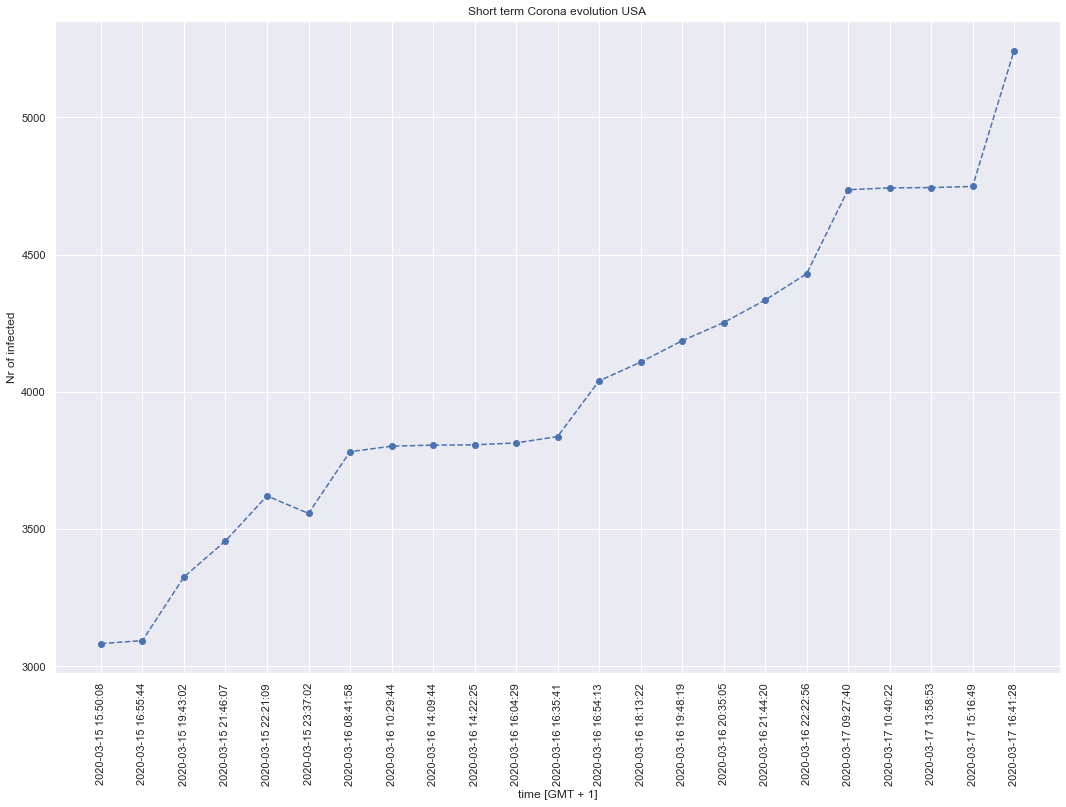

In [292]:


plt.figure(figsize=(18,12))
plt.title('Short term Corona evolution {}'.format(a_country.index[0][0]))
a_country['confirmed'].plot(style ='o--')
plt.xticks(rotation=90)
plt.xticks(range(len(a_country.index)),[a_country.index[i][1] for i in range(len(a_country.index))])
plt.xlabel('time [GMT + 1]')

plt.ylabel('Nr of infected')
#plt.ylabel(r'Nr of infected [ $10^{x}$ ]')
#plt.yscale('log')

filename = 'corona_short_term_' + a_country.index[0][0] + '.jpg'
plt.savefig (filename,format='jpg')


In [293]:
top_dead_pct = df.loc[df['confirmed'] > 500].sort_values('dead_pct',ascending=False)
top_dead_pct

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
Italy,27980.0,NaN,NaN,NaN,2158.0,NaN,2749.0,23073.0,1851.0,NaN,7.712652,2020-03-17 16:41:28
Iran,16169.0,14991.0,1178.0,1.078580,988.0,135.0,5389.0,9792.0,NaN,192.5,6.110458,2020-03-17 16:41:28
Spain,11409.0,9942.0,1467.0,1.147556,509.0,167.0,1028.0,9872.0,563.0,244.0,4.461390,2020-03-17 16:41:28
China,80881.0,80860.0,21.0,1.000260,3226.0,13.0,68715.0,8940.0,3226.0,56.2,3.988576,2020-03-17 16:41:28
Japan,878.0,833.0,45.0,1.054022,29.0,1.0,144.0,705.0,41.0,6.9,3.302961,2020-03-17 16:41:28
UK,1950.0,1543.0,407.0,1.263772,56.0,1.0,52.0,1842.0,20.0,28.7,2.871795,2020-03-17 16:41:28
Netherlands,1705.0,1413.0,292.0,1.206653,43.0,19.0,2.0,1660.0,45.0,99.5,2.521994,2020-03-17 16:41:28
France,6633.0,NaN,NaN,NaN,148.0,NaN,12.0,6473.0,400.0,101.6,2.231268,2020-03-17 16:41:28
USA,5243.0,4663.0,580.0,1.124383,94.0,8.0,74.0,5075.0,12.0,15.8,1.792867,2020-03-17 16:41:28
Diamond Princess,696.0,NaN,NaN,NaN,7.0,NaN,456.0,233.0,15.0,NaN,1.005747,2020-03-17 16:41:28


In [294]:
country_names = sorted(df.index.values)
#country_names

In [295]:
df.loc[df['confirmed'] > 500 ].sort_values('factor',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
Austria,1332.0,1018.0,314.0,1.308448,4.0,1.0,8.0,1320.0,12.0,147.9,0.300300,2020-03-17 16:41:28
UK,1950.0,1543.0,407.0,1.263772,56.0,1.0,52.0,1842.0,20.0,28.7,2.871795,2020-03-17 16:41:28
Netherlands,1705.0,1413.0,292.0,1.206653,43.0,19.0,2.0,1660.0,45.0,99.5,2.521994,2020-03-17 16:41:28
Malaysia,673.0,566.0,107.0,1.189046,2.0,2.0,49.0,622.0,10.0,20.8,0.297177,2020-03-17 16:41:28
Belgium,1243.0,1058.0,185.0,1.174858,10.0,NaN,14.0,1219.0,33.0,107.3,0.804505,2020-03-17 16:41:28
Spain,11409.0,9942.0,1467.0,1.147556,509.0,167.0,1028.0,9872.0,563.0,244.0,4.461390,2020-03-17 16:41:28
Switzerland,2677.0,2353.0,324.0,1.137697,24.0,5.0,4.0,2649.0,NaN,309.3,0.896526,2020-03-17 16:41:28
USA,5243.0,4663.0,580.0,1.124383,94.0,8.0,74.0,5075.0,12.0,15.8,1.792867,2020-03-17 16:41:28
Germany,8084.0,7272.0,812.0,1.111661,20.0,3.0,67.0,7997.0,2.0,96.5,0.247402,2020-03-17 16:41:28
Iran,16169.0,14991.0,1178.0,1.078580,988.0,135.0,5389.0,9792.0,NaN,192.5,6.110458,2020-03-17 16:41:28


In [296]:
top_10_per_m = df.sort_values('confirmed_per_M',ascending=False).head(10)
top_10_per_m

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
Switzerland,2677.0,2353.0,324.0,1.137697,24.0,5.0,4.0,2649.0,NaN,309.3,0.896526,2020-03-17 16:41:28
Norway,1438.0,1348.0,90.0,1.066766,3.0,NaN,1.0,1434.0,27.0,265.3,0.208623,2020-03-17 16:41:28
Spain,11409.0,9942.0,1467.0,1.147556,509.0,167.0,1028.0,9872.0,563.0,244.0,4.461390,2020-03-17 16:41:28
Iran,16169.0,14991.0,1178.0,1.078580,988.0,135.0,5389.0,9792.0,NaN,192.5,6.110458,2020-03-17 16:41:28
Estonia,225.0,205.0,20.0,1.097561,0.0,NaN,1.0,224.0,NaN,169.6,NaN,2020-03-17 16:41:28
Denmark,960.0,914.0,46.0,1.050328,4.0,NaN,1.0,955.0,18.0,165.7,0.416667,2020-03-17 16:41:28
S. Korea,8320.0,8236.0,84.0,1.010199,81.0,6.0,1401.0,6838.0,59.0,162.3,0.973558,2020-03-17 16:41:28
Qatar,439.0,NaN,NaN,NaN,0.0,NaN,4.0,435.0,NaN,152.4,NaN,2020-03-17 16:41:28
Austria,1332.0,1018.0,314.0,1.308448,4.0,1.0,8.0,1320.0,12.0,147.9,0.300300,2020-03-17 16:41:28
Bahrain,237.0,228.0,9.0,1.039474,1.0,NaN,81.0,155.0,3.0,139.3,0.421941,2020-03-17 16:41:28


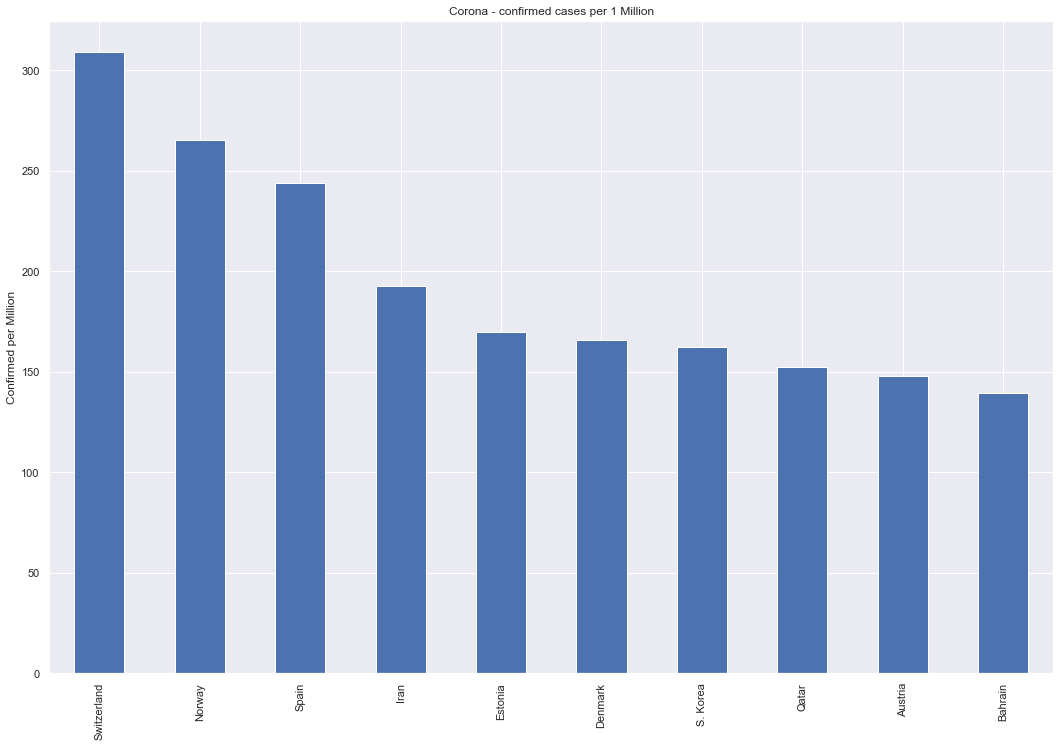

In [297]:
plt.figure(figsize=(18,12))
plt.title('Corona - confirmed cases per 1 Million')
plt.ylabel ('Confirmed per Million')
top_10_per_m['confirmed_per_M'].plot(kind='bar')
plt.savefig('confirmed_per_million.jpg',format='jpg')

In [298]:
totals = pd.DataFrame(df.sum(),columns=['totals'])
totals.drop(['factor','confirmed_per_M','dead_pct','datetime'],inplace=True)
totals

,totals
confirmed,189758
yesterday,145098
inc,7315
dead,7518
dead_inc,371
recovered,80874
active_cases,101366
serious,6514


In [299]:
country_names = list(sorted((df.index.unique().values)))
#country_names

In [300]:
some_countries = ['Sweden','USA','Italy','Spain','Norway','Finland',
                  'Denmark','Singapore','S. Korea','China','Russia',
                 'Poland','Taiwan','Estonia']
countries_of_interest = df.loc[some_countries,:]
countries_of_interest.sort_values('confirmed',inplace=True,ascending=False)
countries_of_interest

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
China,80881.0,80860.0,21.0,1.000260,3226.0,13.0,68715.0,8940.0,3226.0,56.2,3.988576,2020-03-17 16:41:28
Italy,27980.0,NaN,NaN,NaN,2158.0,NaN,2749.0,23073.0,1851.0,NaN,7.712652,2020-03-17 16:41:28
Spain,11409.0,9942.0,1467.0,1.147556,509.0,167.0,1028.0,9872.0,563.0,244.0,4.461390,2020-03-17 16:41:28
S. Korea,8320.0,8236.0,84.0,1.010199,81.0,6.0,1401.0,6838.0,59.0,162.3,0.973558,2020-03-17 16:41:28
USA,5243.0,4663.0,580.0,1.124383,94.0,8.0,74.0,5075.0,12.0,15.8,1.792867,2020-03-17 16:41:28
Norway,1438.0,1348.0,90.0,1.066766,3.0,NaN,1.0,1434.0,27.0,265.3,0.208623,2020-03-17 16:41:28
Sweden,1190.0,1121.0,69.0,1.061552,7.0,NaN,1.0,1182.0,12.0,117.8,0.588235,2020-03-17 16:41:28
Denmark,960.0,914.0,46.0,1.050328,4.0,NaN,1.0,955.0,18.0,165.7,0.416667,2020-03-17 16:41:28
Finland,322.0,278.0,44.0,1.158273,0.0,NaN,10.0,312.0,2.0,58.1,NaN,2020-03-17 16:41:28
Singapore,266.0,243.0,23.0,1.094650,0.0,NaN,114.0,152.0,14.0,45.5,NaN,2020-03-17 16:41:28


In [301]:
countries_of_interest.sort_values('confirmed_per_M',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
Norway,1438.0,1348.0,90.0,1.066766,3.0,NaN,1.0,1434.0,27.0,265.3,0.208623,2020-03-17 16:41:28
Spain,11409.0,9942.0,1467.0,1.147556,509.0,167.0,1028.0,9872.0,563.0,244.0,4.461390,2020-03-17 16:41:28
Estonia,225.0,205.0,20.0,1.097561,0.0,NaN,1.0,224.0,NaN,169.6,NaN,2020-03-17 16:41:28
Denmark,960.0,914.0,46.0,1.050328,4.0,NaN,1.0,955.0,18.0,165.7,0.416667,2020-03-17 16:41:28
S. Korea,8320.0,8236.0,84.0,1.010199,81.0,6.0,1401.0,6838.0,59.0,162.3,0.973558,2020-03-17 16:41:28
Sweden,1190.0,1121.0,69.0,1.061552,7.0,NaN,1.0,1182.0,12.0,117.8,0.588235,2020-03-17 16:41:28
Finland,322.0,278.0,44.0,1.158273,0.0,NaN,10.0,312.0,2.0,58.1,NaN,2020-03-17 16:41:28
China,80881.0,80860.0,21.0,1.000260,3226.0,13.0,68715.0,8940.0,3226.0,56.2,3.988576,2020-03-17 16:41:28
Singapore,266.0,243.0,23.0,1.094650,0.0,NaN,114.0,152.0,14.0,45.5,NaN,2020-03-17 16:41:28
USA,5243.0,4663.0,580.0,1.124383,94.0,8.0,74.0,5075.0,12.0,15.8,1.792867,2020-03-17 16:41:28


In [302]:
def standardize(x):
    return (x - x.mean()) / x.std()

min_confirmed = 0
max_confirmed = 100000 # exclude e.g. China for better view

df_no_extrems = df.loc[ ( ( df['confirmed'] > min_confirmed  ) & ( df['confirmed'] < max_confirmed )) ]
df_no_extrems = df_no_extrems.loc[df_no_extrems['factor'] > 0]
df_no_extrems = df_no_extrems.loc[df_no_extrems['confirmed_per_M'] > 0]

x = df_no_extrems['confirmed_per_M']
x = standardize(x)
y = df_no_extrems['factor']
y = standardize(y)

In [303]:
# 

slope,intercept,_,_,_ = sps.linregress(x,y)

alpha_mu = 0
alpha_sigma = 0.1
beta_mu = -0.2
beta_sigma = 0.3


alpha = pm.Normal('alpha',mu=alpha_mu,tau = 1 / alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu,tau = 1 / beta_sigma ** 2)

# by changing sigma from uniform to lognormal, the y-range of sample plot below
# shrunk a lot

sigma = pm.Uniform('sigma',lower=0,upper=10)

@pm.deterministic()
def linreq_mu(x=x,beta=beta,alpha=alpha):
    return x * beta + alpha

likelihood  = pm.Normal('likelihood',mu=linreq_mu,tau= 1 / sigma ** 2,
                       observed=True,value=y)

model = pm.Model([alpha,beta,sigma,linreq_mu,likelihood])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

mcmc.sample(10000,5000,2)

alpha_samples = mcmc.trace('alpha')[:]
beta_samples = mcmc.trace('beta')[:]
sigma_samples = mcmc.trace('sigma')[:]
linreq_mu_samples = mcmc.trace('sigma')[:]

result = pd.DataFrame({'alpha_post': alpha_samples,
                     'beta_post' : beta_samples,
                     'sigma_post' : sigma_samples,
                     'linreq_mu_post' : linreq_mu_samples})


 [-----------------100%-----------------] 10000 of 10000 complete in 10.7 sec

,alpha_post,beta_post,sigma_post,linreq_mu_post
count,2500.000000,2500.000000,2500.000000,2500.000000
mean,-0.017519,-0.218636,0.997464,0.997464
std,0.065270,0.110933,0.084474,0.084474
min,-0.288973,-0.615472,0.786512,0.786512
25%,-0.056591,-0.289299,0.938562,0.938562
50%,-0.012937,-0.219754,0.994097,0.994097
75%,0.011025,-0.144861,1.046859,1.046859
max,0.223273,0.127700,1.411645,1.411645


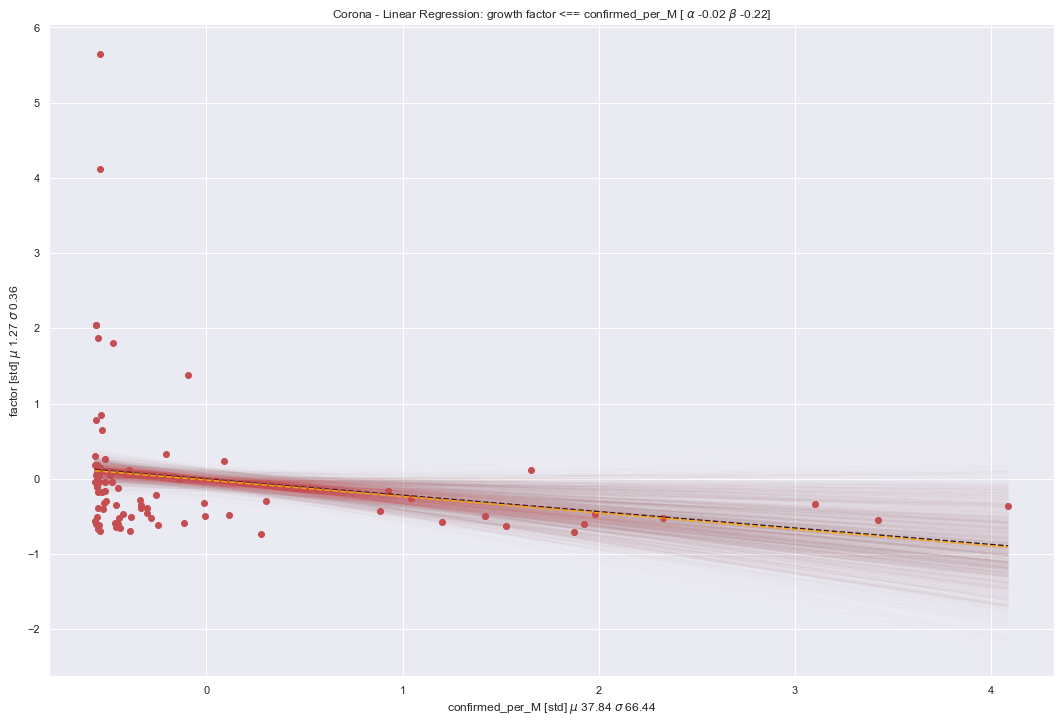

In [304]:

nr_rows = 100
nr_samples = 1000

alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_samples)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_samples)

X = np.linspace(x.min(),x.max(),nr_rows)

line_ys = np.array([X[i] * betas + alphas for i in range(len(X))])

plt.figure(figsize=(18,12))

line_alpha = result['alpha_post'].mean()
line_beta = result['beta_post'].mean()

plt.title(r'Corona - Linear Regression: growth factor <== confirmed_per_M [ $\alpha$ {:.2f} $\beta$ {:.2f}]'.format(
                                                                                        line_alpha,line_beta))

plt.ylabel(r'factor [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['factor'].mean(),
                                                              df_no_extrems['factor'].std()))
plt.xlabel(r'confirmed_per_M [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['confirmed_per_M'].mean(),
                                                             df_no_extrems['confirmed_per_M'].std()))
plt.scatter(x,y,color='r')
plt.plot(X,[X[i] * slope + intercept for i in range(len(X))],color='k',ls='dashed')
plt.plot(X,line_ys,color='r',alpha = 0.01)
plt.plot(X,[X[i] * result['beta_post'].mean() + result['alpha_post'].mean() for i in range(len(X))],
        color='orange',ls='dashed')
result.describe()


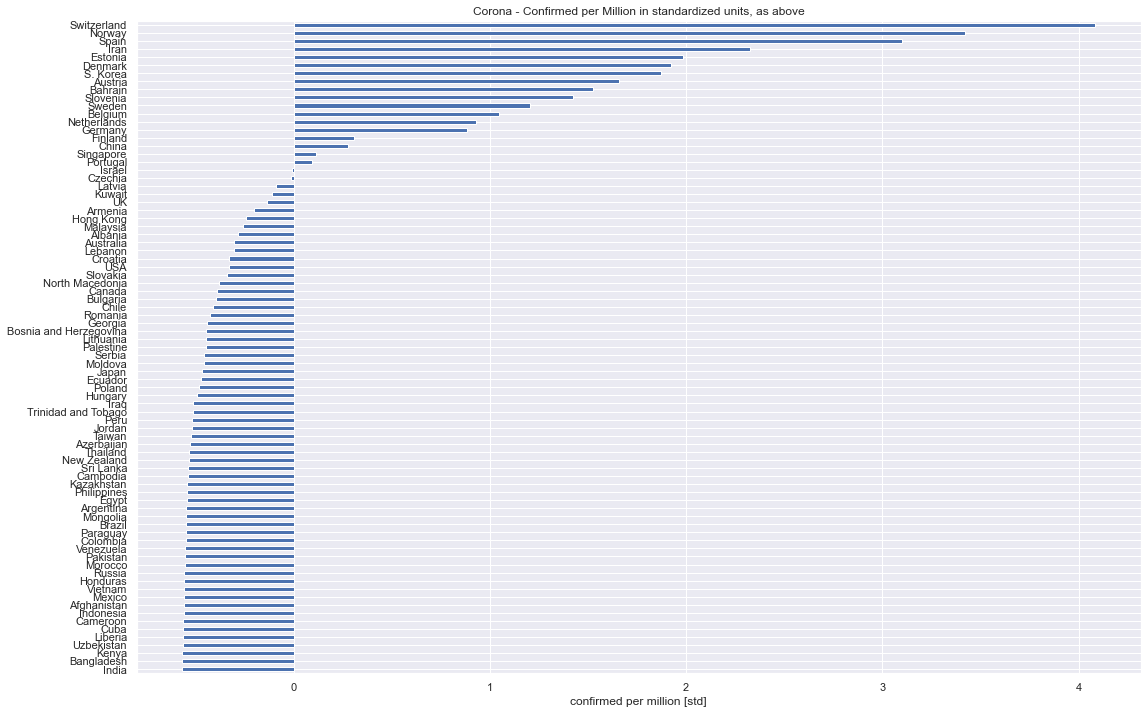

In [305]:
plt.figure(figsize=(18,12))
plt.title ('Corona - Confirmed per Million in standardized units, as above')
plt.xlabel('confirmed per million [std]')
#df_no_extrems['confirmed_per_M'].sort_values().plot(kind='barh')
std_values = standardize(df_no_extrems['confirmed_per_M'])
_= std_values.sort_values().plot(kind='barh')

